<a href="https://colab.research.google.com/github/PrateekTh/EEG-Analysis/blob/main/Canine_EEG_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis of Canine EEGs for Mental State Classification**

This project tries to analyse a Canine Olfactory EEG Dataset containing three classes:

*   Green Tea
*   Black (Chamomile) Tea
*   None

There are various steps involved in the process, and the workflow here may be divided into three major sections:
1. **Setup** - Involves setting up dependencies, and loading data.
2. **Data Preprocessing** - Processing Data and Epochs.
3. **Machine Learning** - Applying different ML Algorithms.

There are several visualisation techniques involved in each step.


# **Setup**

##Installing & Importing Dependencies

The main dependency used is the `MNE` Python Package.

> *MNE is a powerful, open-source python package for exploring, visualizing, and analyzing neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and so on.*

In context of this project, it is definitely sufficient, and provides a lot of tools, functions and a robust framework to process any kind of neurophysiological data.

The `ipympl` package enables using the interactive features of matplotlib in Google Colab, that MNE uses extensively. Still, an offline setup may be better to use such features, but for collaboration purposes, Google Colab has been chosen here.

In [ ]:
!pip install mne
!pip install ipympl

In [ ]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mne

from google.colab import output
output.enable_custom_widget_manager()

file_path = "/content/drive/MyDrive/MNE-Dognosis/pilot_eeg.cdt.cnt"

The dataset is being retrieved from the above mentioned file path.

If a reviewer wishes to run this entire notebook , it is recommended to set up the following directory in google drive:

1.   Create a folder named "`MNE-Dognosis`" in the drive.
2.   Place the following files from the data-set folder directly in this folder:
    *  `pilot_eeg.cdt.cnt`
    *  `experiment_data_segment_1`
    *  `experiment_data_segment_2`

In [ ]:
raw = mne.io.read_raw_cnt("/content/drive/MyDrive/MNE-Dognosis/pilot_eeg.cdt.cnt")

#Printing some details about the read data
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)

print(
    "the (cropped) sample data object has {} time samples and {} channels."
    "".format(n_time_samps, n_chan)
)
print("The last time sample is at {} seconds.".format(time_secs[-1]))
print("The channel names are {}.".format(", ".join(ch_names)))
print()

# Print Bad channels, already marked as bad during acquisition
print("bad channels:", raw.info["bads"])

# Sampling frequency
print(raw.info["sfreq"], "Hz")

# Other miscellaneous acquisition info
print(raw.info)

the (cropped) sample data object has 1256400 time samples and 7 channels.
The last time sample is at 1256.399 seconds.
The channel names are F7, Fz, F8, FCz, A1, Cz, Trigger.

bad channels: ['Trigger']
1000.0 Hz
<Info | 10 non-empty values
 bads: 1 items (Trigger)
 ch_names: F7, Fz, F8, FCz, A1, Cz, Trigger
 chs: 7 EEG
 custom_ref_applied: False
 dig: 10 items (3 Cardinal, 7 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>


<ipython-input-84-adb9a17a98c8>:1: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt("/content/drive/MyDrive/MNE-Dognosis/pilot_eeg.cdt.cnt")


For testing purposes, I also tried to check accuracies and model performance with dropped out channels, by marking a few as bad.

The final analysis does not contain any such channels, except the "Trigger" channel which seems to contain no data.

In [ ]:
#Script for adding bad channels

#raw.info["bads"].append("Fz")
#raw.info["bads"].append("FCz")


In [ ]:
#Info on the bad channel
raw.info["chs"][6]

{'cal': 1.6784699209700358e-11,
 'logno': 7,
 'scanno': 7,
 'range': 1.0,
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'Trigger',
 'unit': 107 (FIFF_UNIT_V),
 'coord_frame': 4 (FIFFV_COORD_HEAD),
 'coil_type': 1 (FIFFV_COIL_EEG),
 'kind': 2 (FIFFV_EEG_CH),
 'loc': array([0.98210168, 0.        , 0.18835151,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan])}

##Importing and Processing Events

Due to the Trigger Channel being bad, and the absence of any other STIM Channels, the events need to be imported from the provided documents.

Subsequently, the data is processed into the required format as per MNE preprocessing needs.

In [ ]:
#Read and Append Data, adjust data types
events_df = pd.read_csv("/content/drive/MyDrive/MNE-Dognosis/experiment_data_segment_1.csv")
temp = pd.read_csv("/content/drive/MyDrive/MNE-Dognosis/experiment_data_segment_2.csv")
events_df = pd.concat([events_df,temp])

#Adjust Data Type
events_df['Experiment Time'] = events_df['Experiment Time'].astype(float)

#Reset Index
events_df.set_index('Experiment Time', inplace=True)
events_df.reset_index(inplace=True)
events_df

Experiment Time Condition    Clock Time
0           2.006433         N  1.693234e+09
1           6.028522         G  1.693234e+09
2          10.050210         C  1.693234e+09
3          14.071487         N  1.693234e+09
4          18.088619         G  1.693234e+09
..               ...       ...           ...
175      1005.783578         N  1.693235e+09
176      1009.812305         C  1.693235e+09
177      1013.842593         G  1.693235e+09
178      1017.869502         C  1.693235e+09
179      1021.896949         N  1.693235e+09

[180 rows x 3 columns]

In [ ]:
#Mapping the given events to event IDs
condition_map = {'N': 1, 'G': 2, 'C': 3}
events_df['Condition'] = events_df['Condition'].map(condition_map)
events_df

Experiment Time  Condition    Clock Time
0           2.006433          1  1.693234e+09
1           6.028522          2  1.693234e+09
2          10.050210          3  1.693234e+09
3          14.071487          1  1.693234e+09
4          18.088619          2  1.693234e+09
..               ...        ...           ...
175      1005.783578          1  1.693235e+09
176      1009.812305          3  1.693235e+09
177      1013.842593          2  1.693235e+09
178      1017.869502          3  1.693235e+09
179      1021.896949          1  1.693235e+09

[180 rows x 3 columns]

In [ ]:
#Creating a Numpy int Array from the Dataframe
events = np.empty((len(events_df), 3), dtype=np.int64)

for i, row in events_df.iterrows():
    experiment_time = float(row['Experiment Time'])
    zero = 0
    condition = row['Condition']

    # Assign values to the numpy array
    events[i] = [int(experiment_time *1000), int(zero), int(condition)]

events

array([[   2006,       0,       1],
       [   6028,       0,       2],
       [  10050,       0,       3],
       [  14071,       0,       1],
       [  18088,       0,       2],
       [  22099,       0,       3],
       [  26117,       0,       2],
       [  30133,       0,       3],
       [  34151,       0,       1],
       [  38165,       0,       2],
       [  42184,       0,       3],
       [  46205,       0,       1],
       [  50219,       0,       2],
       [  54237,       0,       1],
       [  58253,       0,       3],
       [  62268,       0,       2],
       [  66285,       0,       3],
       [  70306,       0,       1],
       [  74327,       0,       2],
       [  78347,       0,       3],
       [  82366,       0,       1],
       [  86387,       0,       3],
       [  90407,       0,       2],
       [  94425,       0,       1],
       [  98445,       0,       3],
       [ 102462,       0,       2],
       [ 106478,       0,       1],
       [ 110499,       0,   

##Visualising Events

The events thus adjusted to the required format, can now be visualised with respect to the time dimension.

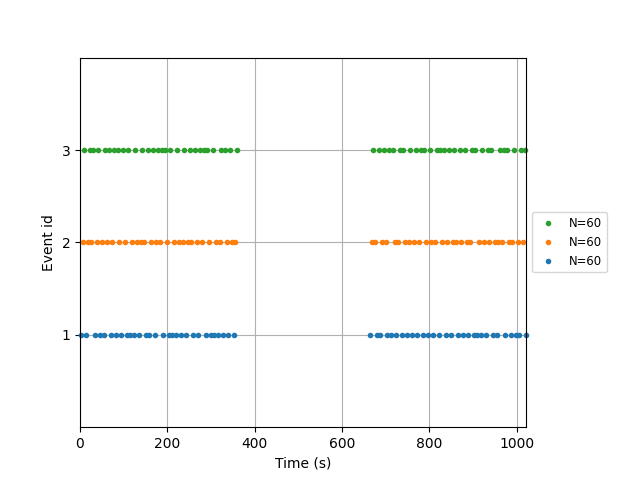

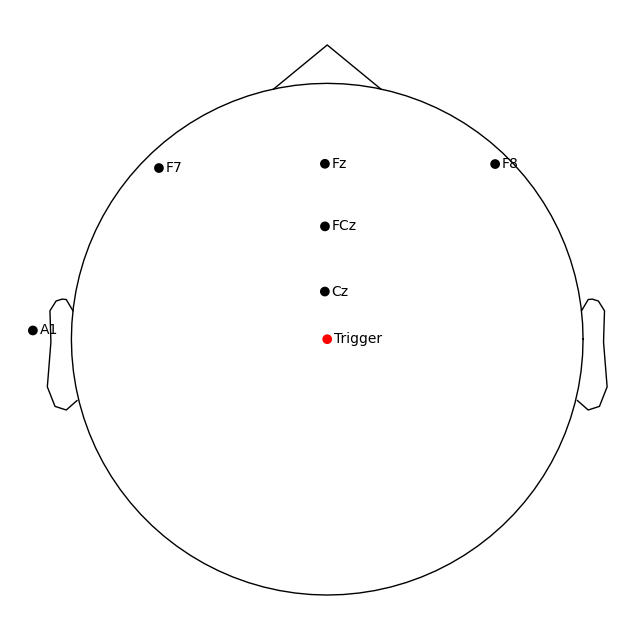

In [ ]:
fig = mne.viz.plot_events(
    events, sfreq=raw.info["sfreq"], first_samp=raw.first_samp
)

# Apply a template montage directly, without preloading
raw.set_montage("standard_1020", on_missing='ignore')
fig = raw.plot_sensors(show_names=True)

# **Processing Data**

## Visualising Raw Data

Effective window size : 2.048 (s)


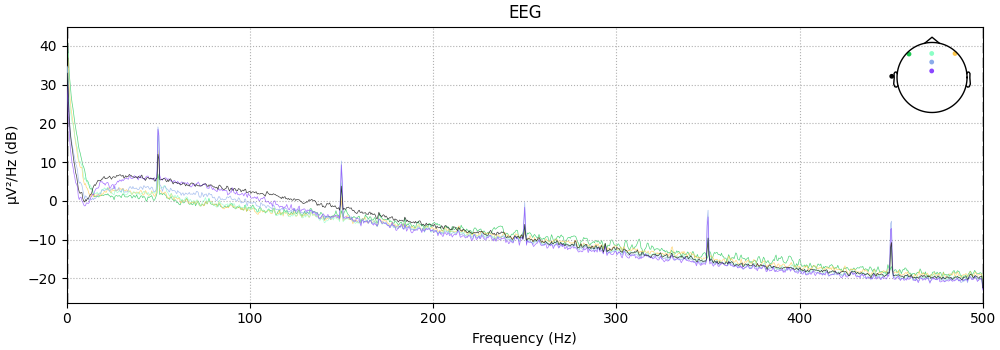

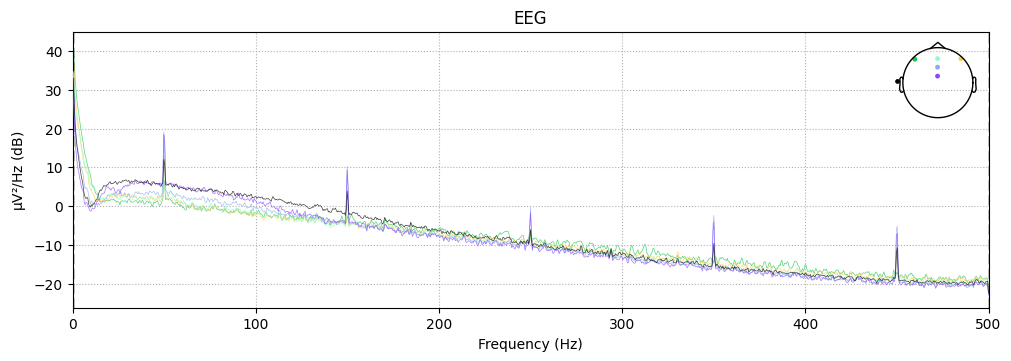

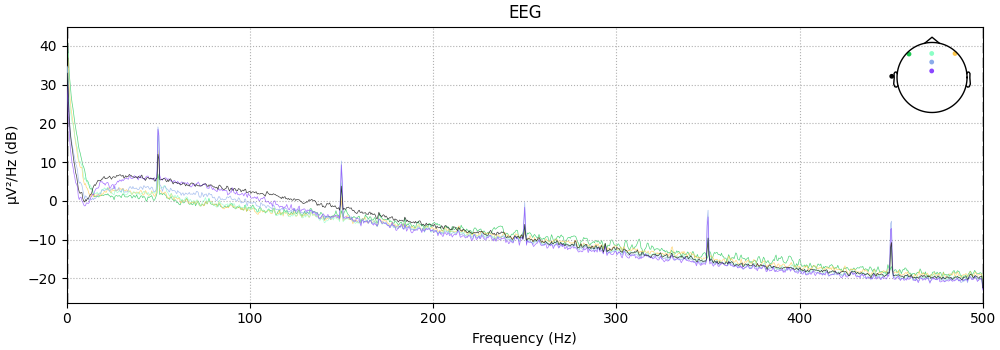

In [ ]:
#Checking the PSD plot
raw.compute_psd().plot(picks="data", exclude="bads")

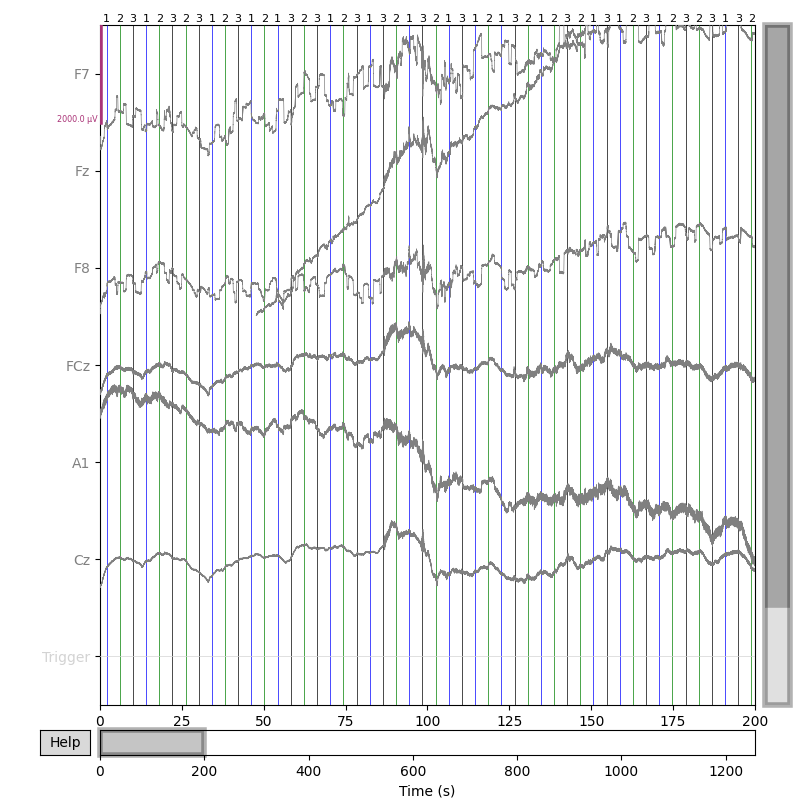

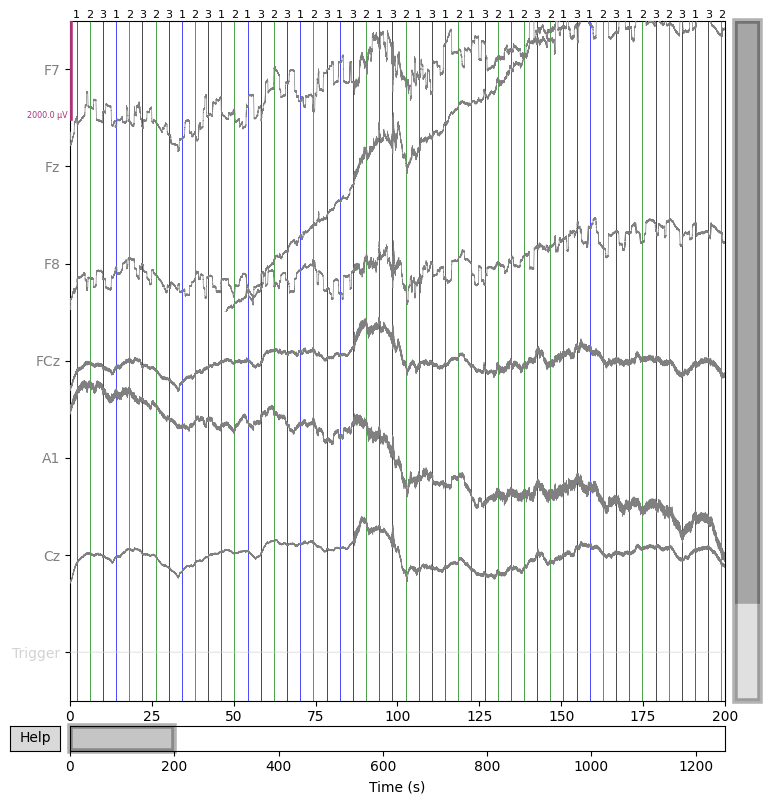

In [ ]:
#Complete channel plot
raw.plot(
    events=events,
    event_color={1: "b", 2: "g", 3: "k"},
    start=0,
    duration=200,
    color="gray",
    #butterfly=True,
    scalings=1e-3
)

#A dictionary for reference to
#dict(mag=1e-12, grad=4e-11, eeg=20e-6, eog=150e-6, ecg=5e-4, emg=1e-3, ref_meg=1e-12, misc=1e-3, stim=1, resp=1, chpi=1e-4, whitened=1e2)

## Filtering Data

In [ ]:
# Adding a Band-pass Filter
raw_test = raw.copy()
raw_test.load_data()
raw_filtered = raw_test.copy().filter(l_freq=0.1, h_freq=40)

Reading 0 ... 1256399  =      0.000 ...  1256.399 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 s)



##Filtered Graphics

/usr/local/lib/python3.10/dist-packages/mne/viz/_mpl_figure.py:2365: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(FigureClass=FigureClass, **kwargs)


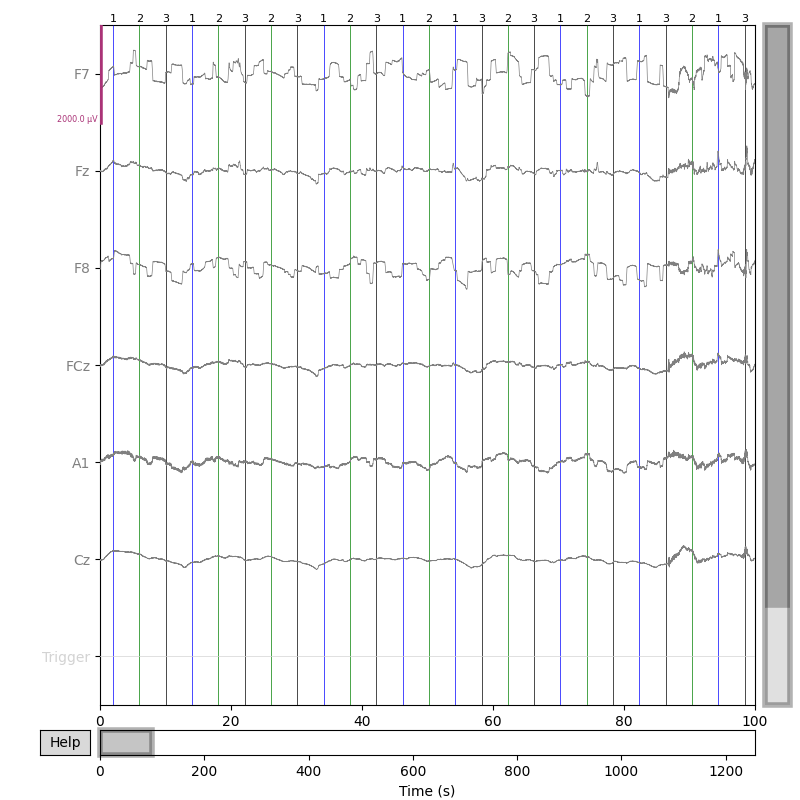

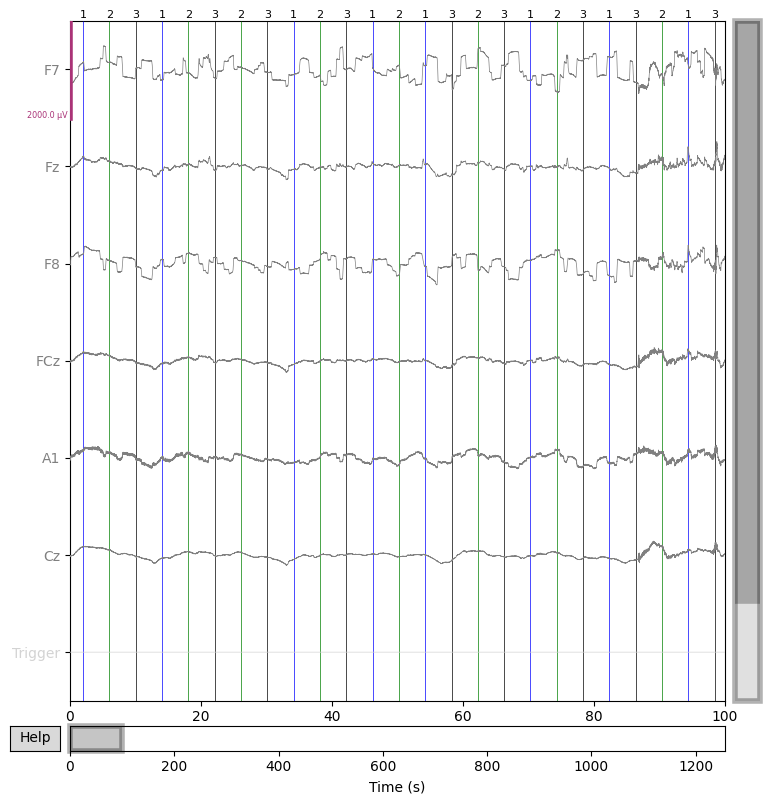

In [ ]:
raw_filtered.plot(
    events=events,
    event_color={1: "b", 2: "g", 3: "k"},
    start=0,
    duration=100,
    color="gray",
    #butterfly=True,
    scalings=1e-3
)

Effective window size : 2.048 (s)


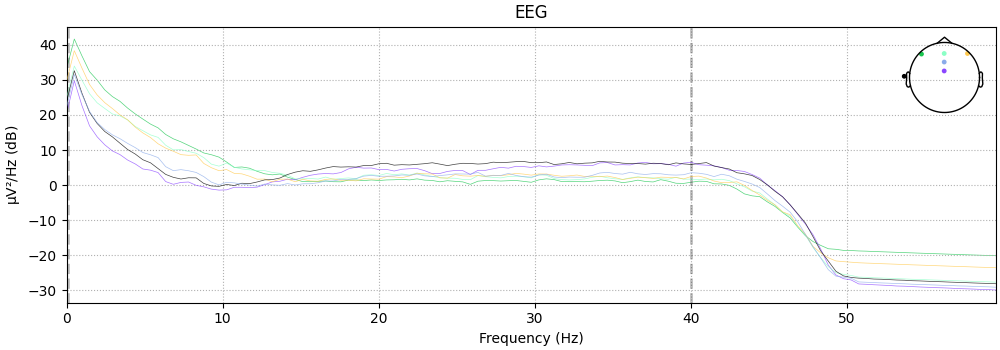

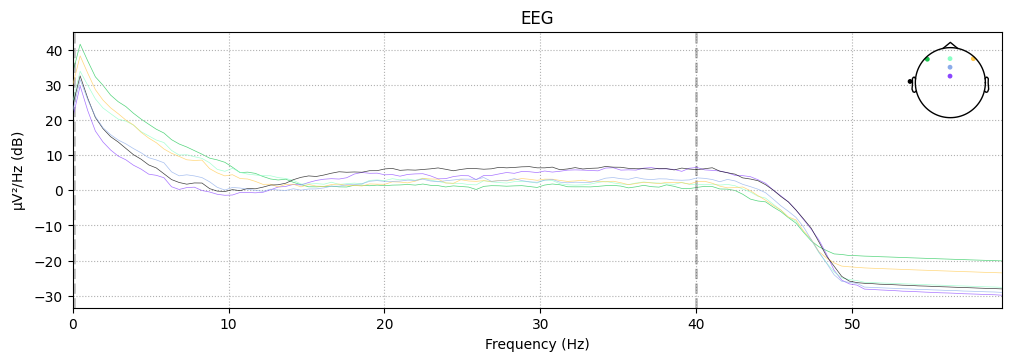

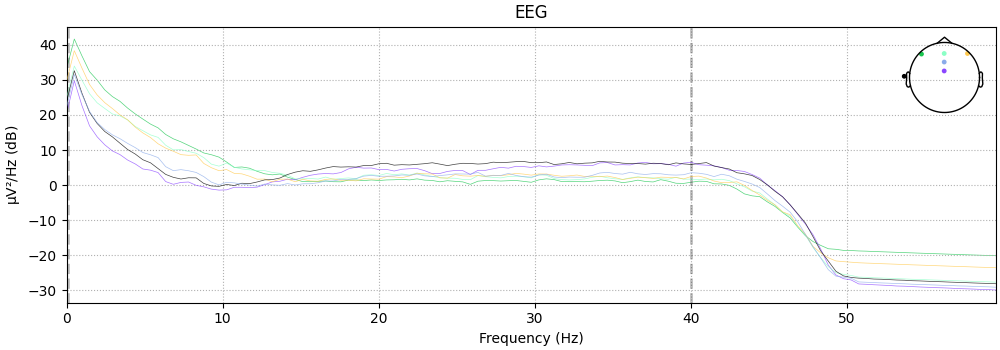

In [ ]:
raw_filtered.compute_psd( fmin=0, fmax=60).plot(picks="data", exclude="bads")

#**Processing Epochs**

Since the data is in a continuous format, we need to divide it into singular time based parts, which will be done with respect to the provided events and the correspondingf timestamps.

>*MNE provides several methods to create these "Epochs", on which we will subsequently perform several other analysis techniques.*



##Generation

The generation involves several parameters. After experimenting with the results, settled onto epochs of length 1100ms for the current dataset.

In [ ]:
#Setting up event ID and Color Mapping dictionaries
event_id = {
    'None': 1,
    'Tea/Green': 2,
    'Tea/Black': 3
}

color_dict = {
    'None' : 'b',
    'Tea/Green' : 'g',
    'Tea/Black' : 'k'
}

In [ ]:
#Generating Epochs

t_min = -0.1
t_max = 1.

baseline = (None, None)

epochs = mne.Epochs(raw_filtered,
                    events=events,
                    event_id=event_id,
                    tmin = t_min,
                    tmax = t_max,
                    baseline = baseline,
                    preload = True)

epochs

Not setting metadata
180 matching events found
Setting baseline interval to [-0.1, 1.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 1101 original time points ...
0 bad epochs dropped


<Epochs |  180 events (all good), -0.1 – 1 s, baseline -0.1 – 1 s, ~10.6 MB, data loaded,
 'None': 60
 'Tea/Green': 60
 'Tea/Black': 60>

##Epoched Data Visualisation

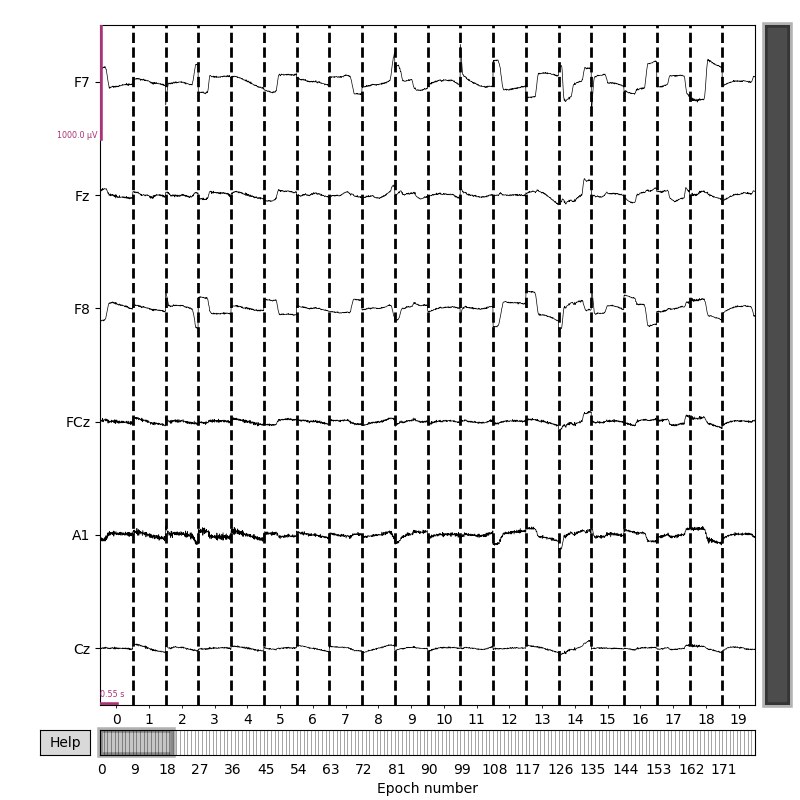

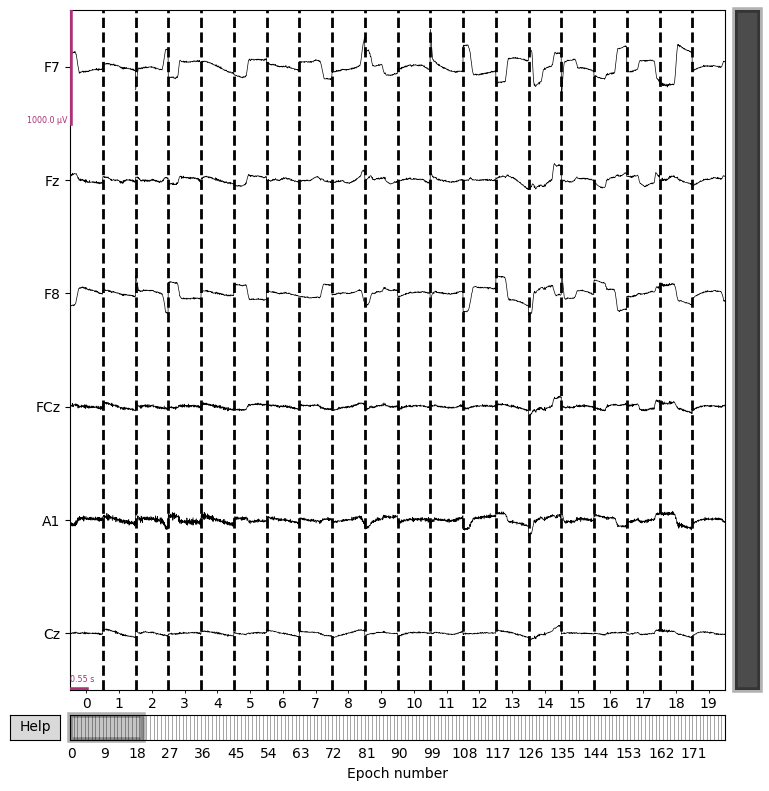

In [ ]:
epochs.plot(scalings=5e-4)

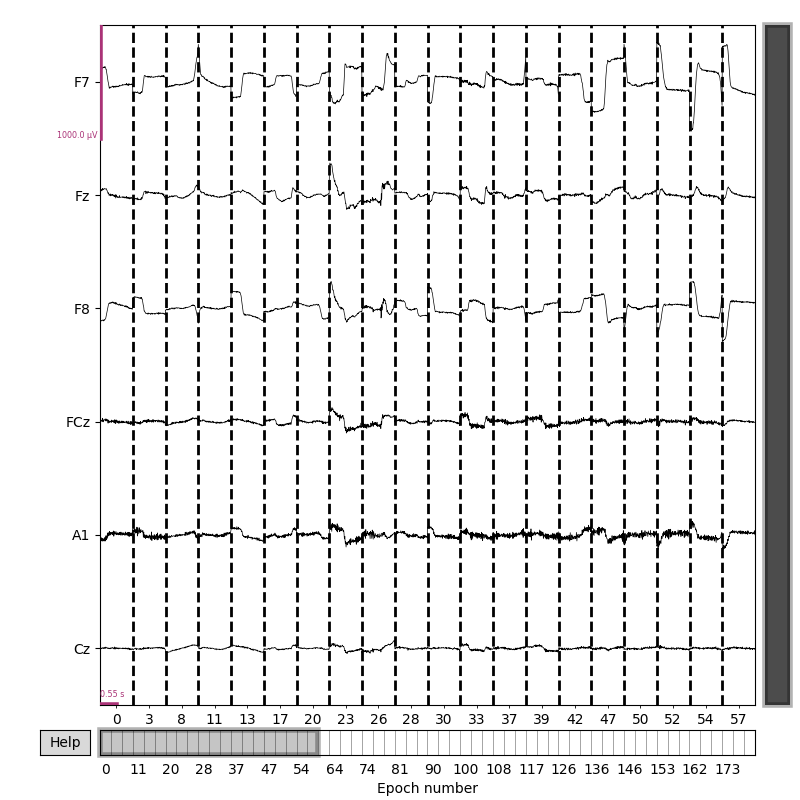

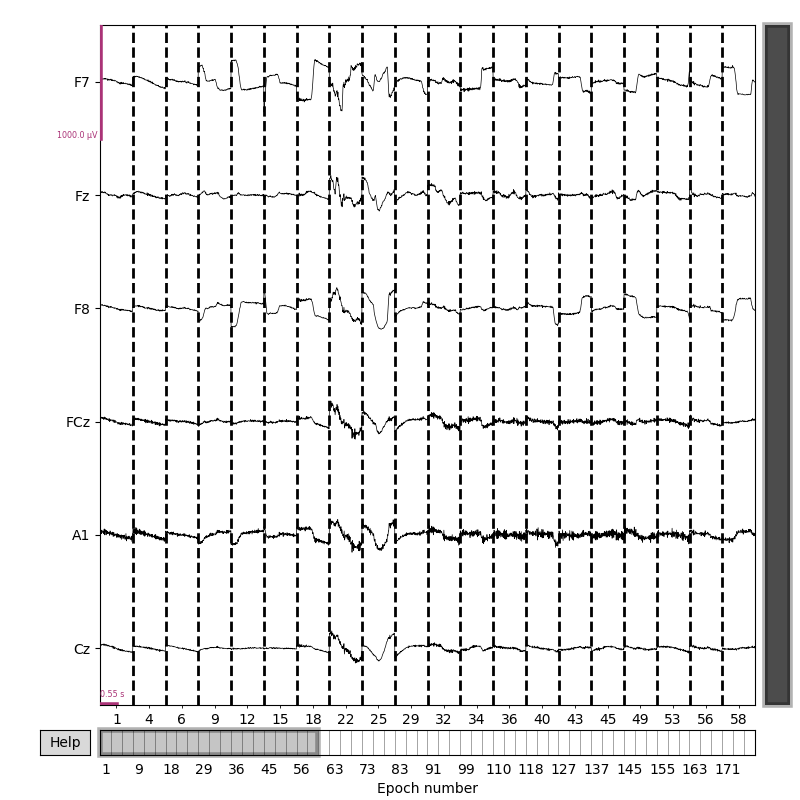

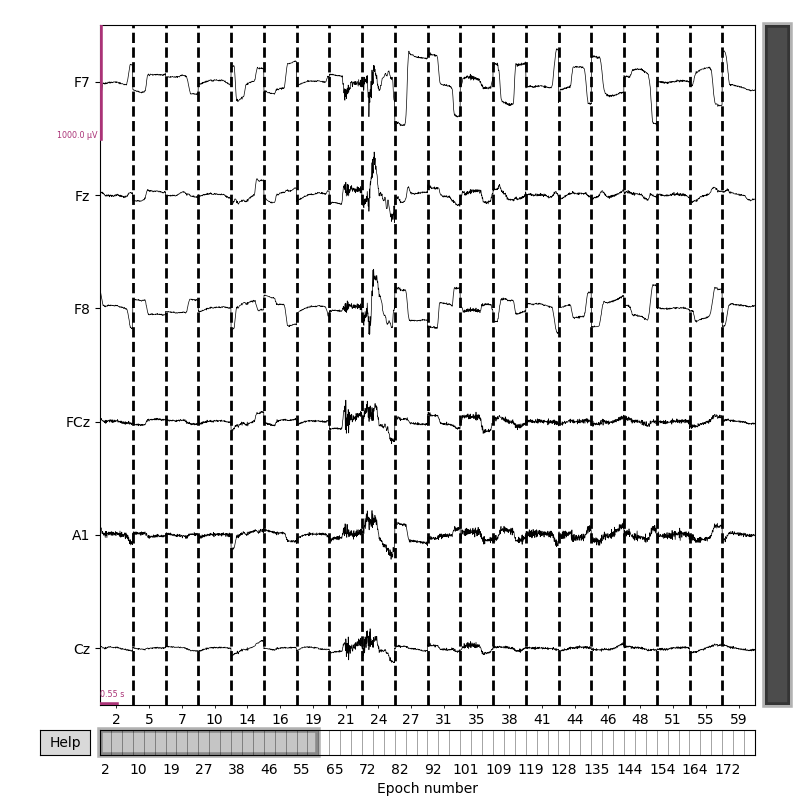

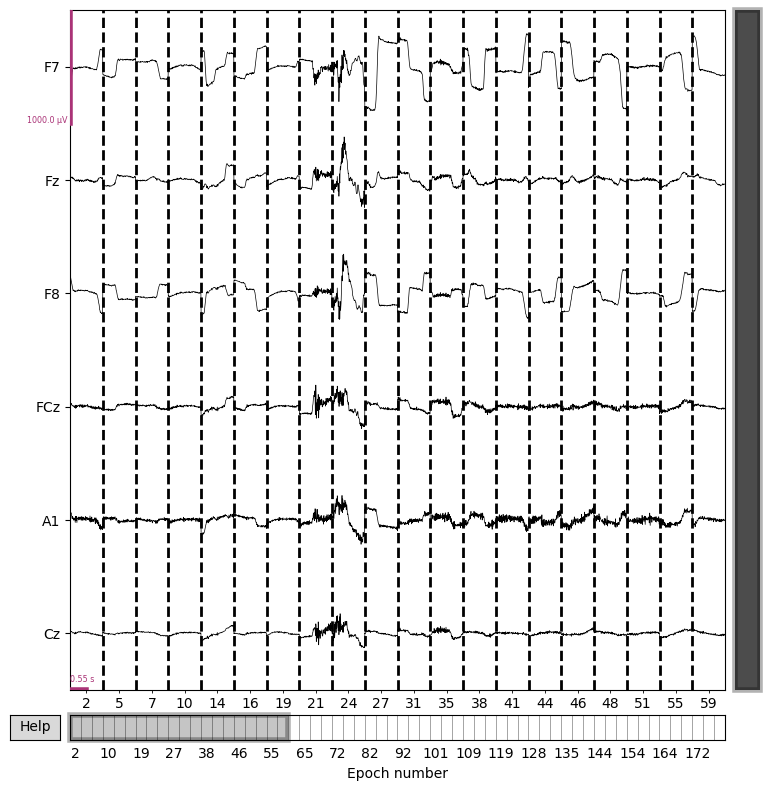

In [ ]:
epochs['None'].plot(scalings=5e-4,)
epochs['Tea/Green'].plot(scalings=5e-4,)
epochs['Tea/Black'].plot(scalings=5e-4,)

In [ ]:
#epochs['Tea/Green'].plot_image()
#epochs['None'].plot_image()
#epochs['Tea/Black'].plot_image()

## Evoked Data

Evoked Data is a generalised form of all epochs, based on a decided function.

Here, the average of all the epochs of each class is used to generate the evoked data for that particular class.

In [ ]:
evoked_green = epochs['Tea/Green'].average()
evoked_none = epochs['None'].average()
evoked_black = epochs['Tea/Black'].average()

evoked_black

<Evoked | 'Tea/Black' (average, N=60), -0.1 – 1 s, baseline -0.1 – 1 s, 7 ch, ~77 kB>

###Evoked Data Plots

The evoked data plots can be observed to see differences in the average class waveform.

The comparision plot shows a significant offset in brain activity, which strengthens the argument to use ML based classification in this situation.

No projector specified for this dataset. Please consider the method self.add_proj.


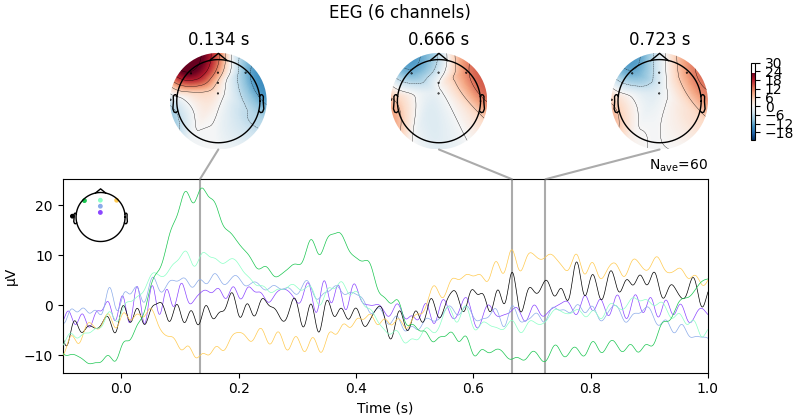

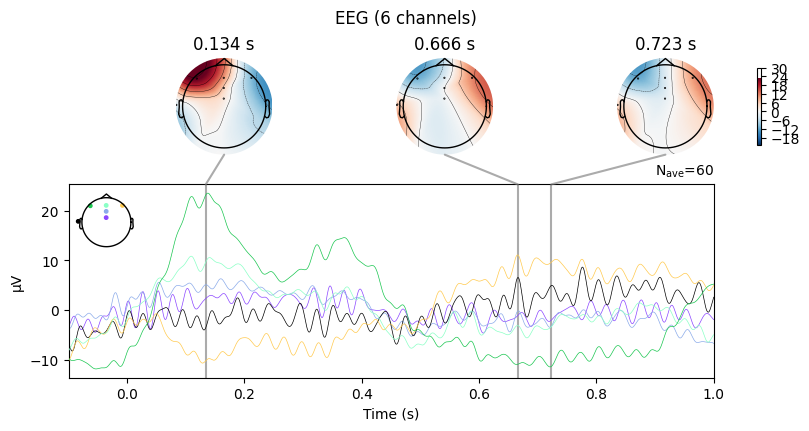

In [ ]:
evoked_none.plot_joint(picks='eeg')

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


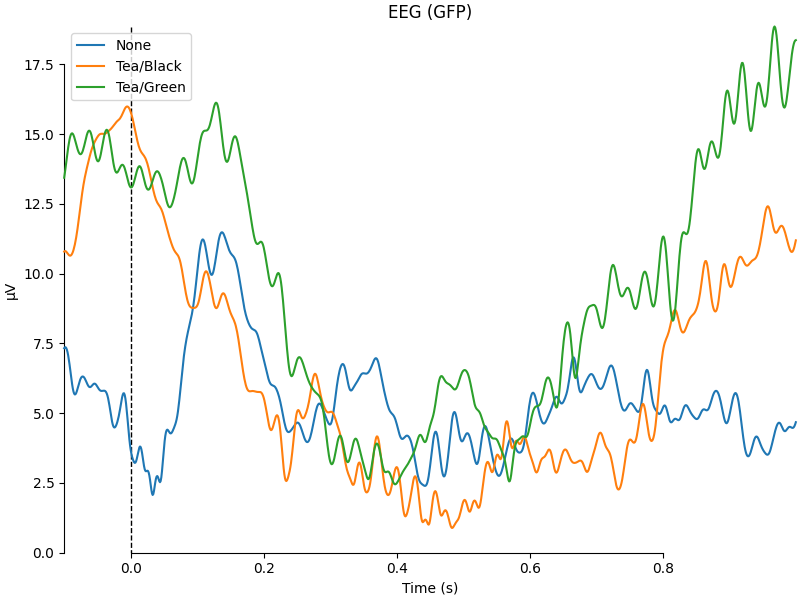

[<Figure size 800x600 with 1 Axes>]

In [ ]:
mne.viz.plot_compare_evokeds([evoked_none, evoked_black, evoked_green], picks='eeg')

#**Artifact Removal**

> This part may be skipped for the current dataset, the reason being that I did not find any significant change or denoising for the signals in question.

SSP Projection Based Artifact Removal can be applied if ECG, EOG channels are available.

The following is ICA (Independent Component Analysis) Based Artifact Removal:

Reading 0 ... 1256399  =      0.000 ...  1256.399 secs...


<ipython-input-101-d2160604628a>:1: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw_clean = mne.io.read_raw_cnt("/content/drive/MyDrive/MNE-Dognosis/pilot_eeg.cdt.cnt")


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 11001 samples (11.001 s)



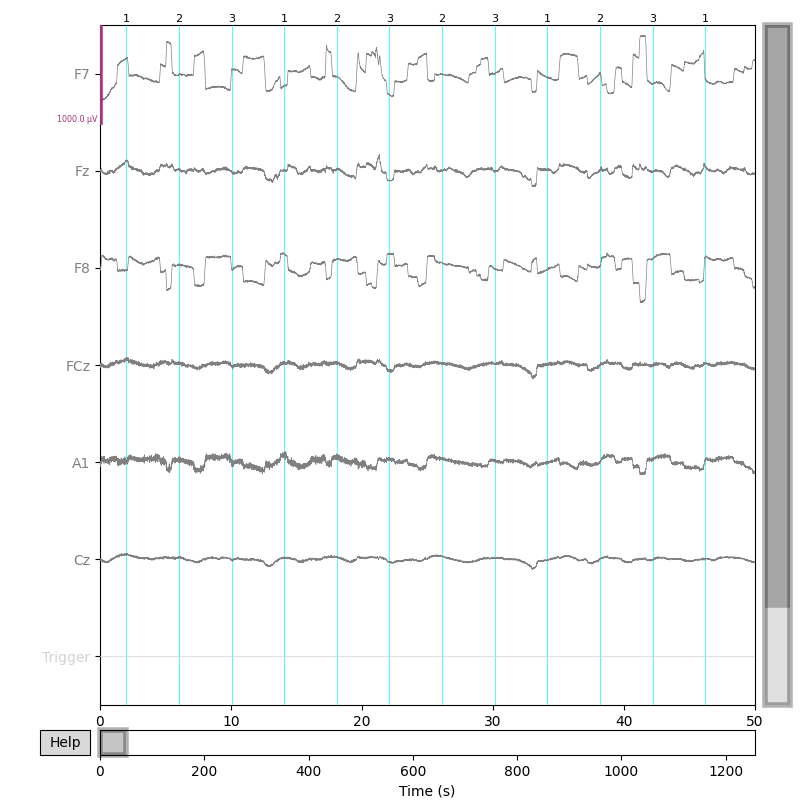

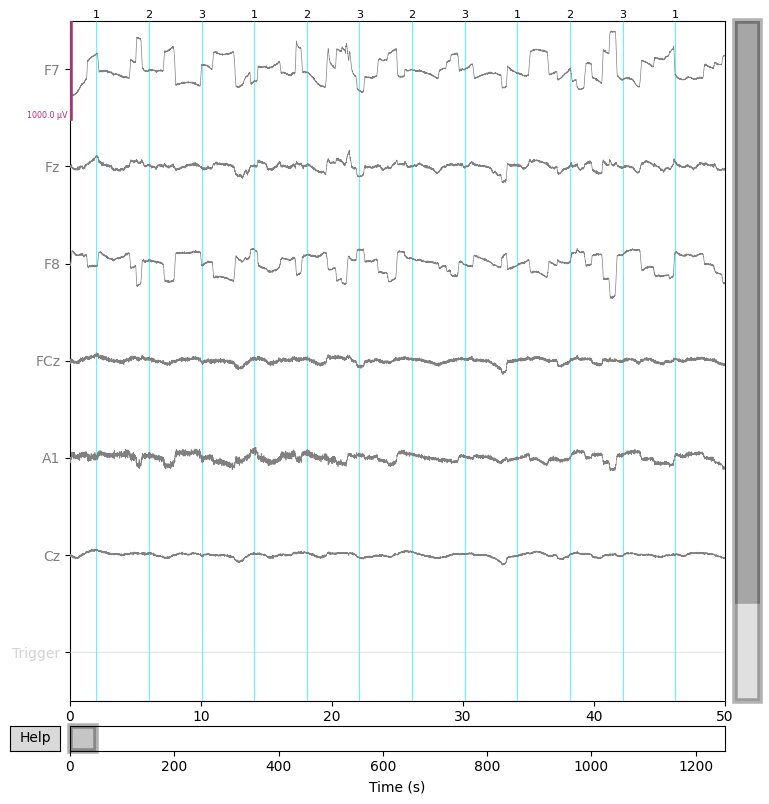

In [ ]:
raw_clean = mne.io.read_raw_cnt("/content/drive/MyDrive/MNE-Dognosis/pilot_eeg.cdt.cnt")
raw_clean.load_data()
raw_clean.filter(l_freq=0.3, h_freq=50)

raw_clean.plot(
    events=events,
    start=0,
    duration=50,
    color="gray",
    scalings=5e-4
)

In [ ]:
t_min = -0.5
t_max = 2.5

baseline = (None, None)

epochs_ica = mne.Epochs(raw_clean,
                    events=events,
                    event_id=event_id,
                    tmin = t_min,
                    tmax = t_max,
                    baseline = baseline,
                    preload = True)

epochs_ica

Not setting metadata
180 matching events found
Setting baseline interval to [-0.5, 2.5] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 3001 original time points ...
0 bad epochs dropped


<Epochs |  180 events (all good), -0.5 – 2.5 s, baseline -0.5 – 2.5 s, ~28.9 MB, data loaded,
 'None': 60
 'Tea/Green': 60
 'Tea/Black': 60>

In [ ]:
#ICA Analysis

n_components = 0.9 #set higher
method = 'fastica'
max_iter = 500 #set higher
fit_params = dict(fastica_it = 5)
random_state = 42

ica = mne.preprocessing.ICA(n_components = n_components,
                            method = method,
                            max_iter = max_iter,
                            random_state = random_state)
ica.fit(epochs_ica)

Fitting ICA to data using 6 channels (please be patient, this may take a while)


<ipython-input-103-416df11d92e7>:13: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs_ica)


Selecting by explained variance: 2 components
Fitting ICA took 1.0s.


<ICA | epochs decomposition, method: fastica (fit in 4 iterations on 540180 samples), 2 ICA components (6 PCA components available), channel types: eeg, no sources marked for exclusion>

In [ ]:
epochs_clean = ica.apply(epochs_ica.copy())

Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 6 PCA components


<ipython-input-104-f3de35b1b1ca>:1: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs_clean = ica.apply(epochs_ica.copy())


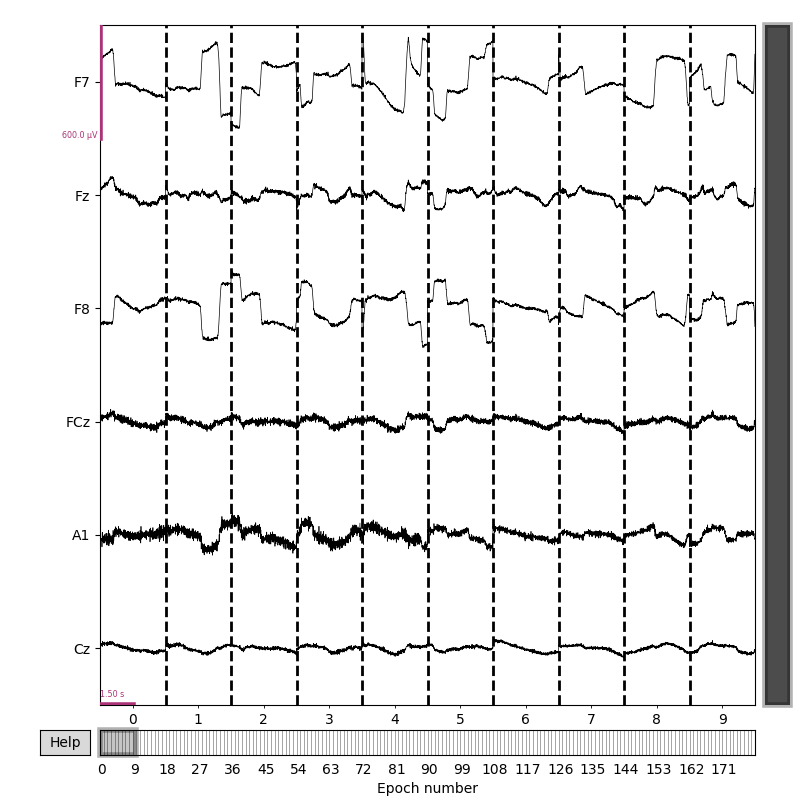

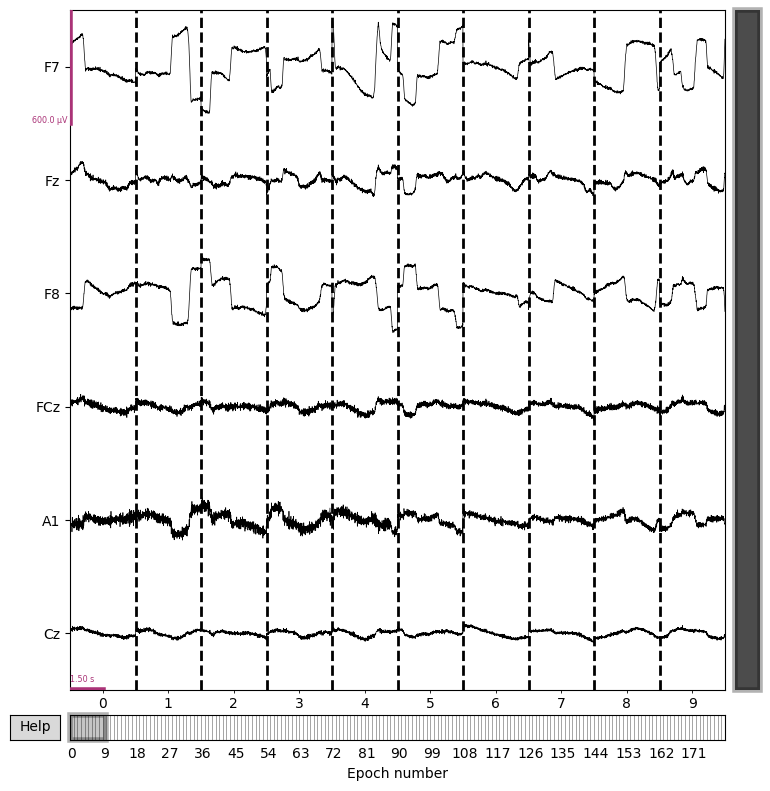

In [ ]:
# epochs_clean.plot(
#     n_epochs=10,
#     scalings=3e-4
# )

epochs_ica.plot(
    n_epochs=10,
    scalings=3e-4
)

# **Machine Learning**

The following part contains the data modelling and machine learning techniques used.

A few techniques have been used, to ascertain the better ones out of multiple techniques to build a model on epoched data. These can be classified into two major types:
* **With Feature Extraction** : Various waveform based features are extracted from each epoch, for each channel. Provides a wholistic (more promising) analysis, but may affect performance if irrelevant features are chosen, or relevant features missed.
* **Without Feature Extraction** : The time based waveform of each epoch with each data sample is submitted as a feature, and a direct analyis is done. Does not lose any information, but a large set of features without a substantial set of labels would result in a rather unreliable model.

Both methods have more to it, and my recommendation is to try and process initial datasets via both methods.

## Dataset

Creating the Features (X) and labels (y) for use in models.

Here, the data from the two main events is used: Green Tea and Black Tea.

In [ ]:
epochs_tea = epochs['Tea']

In [ ]:
y = np.empty(len(epochs_tea.events), dtype=int)

idx_green = epochs_tea.events[:,2] == epochs.event_id['Tea/Green']
idx_black = epochs_tea.events[:,2] == epochs.event_id['Tea/Black']

y[idx_green] = 0
y[idx_black] = 1

y.size

120

In [ ]:
epochs_data_eeg = epochs_tea.copy().pick_types(eeg=True)
data = epochs_data_eeg.get_data()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<ipython-input-37-6e13a39c42cb>:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_data_eeg.get_data()


## With Feature Extraction

Extracting feature based data from every epoch.

The current features include:
  * Mean
  * Spectral Entropy
  * Kurtosis
  * Approximate Entropy
  * Higuchi Fractal Dimension

### *Logistic Regression*



In [ ]:
!pip install mne-features

In [ ]:
from mne_features.feature_extraction import FeatureExtractor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (GridSearchCV, cross_val_score, StratifiedKFold)
from sklearn.pipeline import Pipeline

print(__doc__)

Automatically created module for IPython interactive environment


In [ ]:
# Feature List: ['higuchi_fd', 'mean', 'spect_entropy', 'kurtosis', 'app_entropy']

selected_funcs=['higuchi_fd', 'mean', 'spect_entropy', 'kurtosis', 'app_entropy']

pipe = Pipeline([('fe', FeatureExtractor(sfreq=raw.info['sfreq'],
                                         selected_funcs=selected_funcs)),
                 ('scaler', StandardScaler()),
                   ('clf', LogisticRegression(random_state=42, solver='lbfgs'))])
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
y = y

In [ ]:
scores = cross_val_score(pipe, data, y, cv=skf)
print('Cross-validation accuracy score (with default parameters) = %1.3f '
      '(+/- %1.5f)' % (np.mean(scores), np.std(scores)))

Cross-validation accuracy score (with default parameters) = 0.683 (+/- 0.05137)


### *Hyperparameter Tuning with Grid Search CV*

Since there's a host of functions from the selected ones that take more input for different states, there's several ways to configure these parameters, and consequently some parameters yield better results than others.

This "Hyperparameter Tuning" is done here using `Grid Search CV` from the `scikit-learn` library. It runs through all the different parameters that is fed into the parameter grid and produces the best combination of parameters, based on the scoring metric, which is the prediction accuracy of the model in the current case.

> *Note: This may take some time*

In [ ]:
#Parameter Grid
params_grid = {'fe__app_entropy__emb': [2],'fe__higuchi_fd__kmax': [10]}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
gs = GridSearchCV(estimator=pipe, param_grid=params_grid,
                  cv=cv, n_jobs=1,
                  return_train_score=True)
gs.fit(data, y)

# Best parameters obtained with GridSearchCV:
print(gs.best_params_)

{'fe__app_entropy__emb': 2, 'fe__higuchi_fd__kmax': 10}


In [ ]:
scores = pd.DataFrame(gs.cv_results_)
print(scores[['params', 'mean_test_score', 'mean_train_score']])

                                              params  mean_test_score  \
0  {'fe__app_entropy__emb': 2, 'fe__higuchi_fd__k...         0.666667   

   mean_train_score  
0             0.875  


In [ ]:
gs_best = gs.best_estimator_
new_scores = cross_val_score(gs_best, data, y, cv=skf)

print('Cross-validation accuracy score (with optimized parameters) = %1.3f '
      '(+/- %1.5f)' % (np.mean(new_scores), np.std(new_scores)))

Cross-validation accuracy score (with optimized parameters) = 0.683 (+/- 0.05137)


### *Logistic Regression using KFold Cross Validation*

In [ ]:
from mne_features.feature_extraction import extract_features
selected_funcs = {'higuchi_fd', 'mean', 'spect_entropy'}
X_new = extract_features(data, raw.info['sfreq'], selected_funcs)

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('lr', LogisticRegression(random_state=1, solver='lbfgs'))])

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=3, shuffle=True, random_state=1)
scores = cross_val_score(pipe, X_new, y, scoring='accuracy', cv=kf)

print('Cross-validation accuracy score = %1.3f (+/- %1.4f)' % (np.mean(scores),
                                                               np.std(scores)))

Cross-validation accuracy score = 0.617 (+/- 0.0118)


###*SVM on Extracted Features*



In [ ]:
#Reshaping data
n_trials = data.shape[0]

X = data.reshape(n_trials, -1)
print(X.shape)

(120, 6606)


In [ ]:
import sklearn as skl
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
clf = skl.pipeline.make_pipeline(skl.preprocessing.StandardScaler(), skl.svm.SVC())

n_splits = 5
scoring = 'roc_auc'
cv = skl.model_selection.StratifiedKFold(n_splits=n_splits)
scores = skl.model_selection.cross_val_score(clf, X=X_new, y=y, cv=cv, scoring=scoring)

roc_auc_mean = round(np.mean(scores), 3)
roc_auc_sstd = round(np.std(scores), 3)

print("roc_auc_mean: " + str(roc_auc_mean) + "\n" + "roc_auc_std: " + str(roc_auc_sstd))

roc_auc_mean: 0.603
roc_auc_std: 0.108


## No Feature Extraction

Using all the sampled datapoints per epoch as the Features

In [ ]:
#Setting up the data
n_trials = data.shape[0]
X = data.reshape(n_trials, -1)
print(X.shape)

(120, 6606)


###SVM

Training and running an SVM Classifire on the data.

Evakuation Metric: *Accuracy*

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=11, stratify = y)

# Feature Scaling

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Training a SVM classifier using SVC class
svm = SVC(kernel= 'linear', random_state=1, C=0.1)
svm.fit(X_train_std, y_train)

# Mode performance

y_pred = svm.predict(X_test_std)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.650


###KFold Stratified - SVM

To generate test sets for the classifier such that all contain the same distribution of classes, or as close as possible.

Evaluation parameters:
* *ROC-AUC Mean*
* *ROC-AUC Standard Deviation*


In [ ]:
import sklearn as skl

clf = skl.pipeline.make_pipeline(skl.preprocessing.StandardScaler(), skl.svm.SVC())

In [ ]:
n_splits = 4
scoring = 'roc_auc'
cv = skl.model_selection.StratifiedKFold(n_splits=n_splits)
scores = skl.model_selection.cross_val_score(clf, X=X, y=y, cv=cv, scoring=scoring)


In [ ]:
roc_auc_mean = round(np.mean(scores), 3)
roc_auc_sstd = round(np.std(scores), 3)

In [ ]:
scores

array([0.38666667, 0.52888889, 0.37777778, 0.35555556])

In [ ]:
print("roc_auc_mean: " + str(roc_auc_mean) + "\n" + "roc_auc_std: " + str(roc_auc_sstd))

roc_auc_mean: 0.412
roc_auc_std: 0.068
